In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm, trange
import itertools
import random
import time
from sklearn.preprocessing import OneHotEncoder
from collections import deque
import copy

#Personal library
import sys
if "../" not in sys.path:
  sys.path.append("../") 
from lib import plotting

# Sparse Reward Problem.
# We should use prioritize reward.

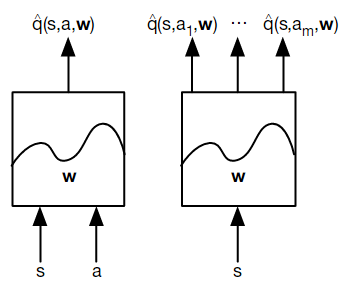
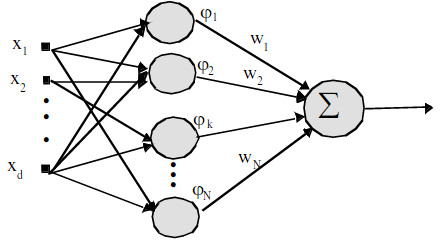

We can think of X features as a combination of states and number of actions.
SO as we see here There are 2 different Models, We'll be immitating the first model first

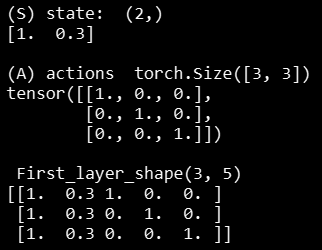 
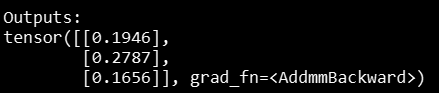

First layer: [state,one_hot_encoded_action]
2nd Layer: Hiddenlayer 128
Last layer : Q singular, but since we plugged in many First layer, we get many Q's

1. For states : Get min max of each state, normalize each state using z transform
2. For actions: Get a one hot encoding of all actions
3. Concatenate the states and actions and pass it into the neural network and it should.

In [2]:
class ANeuralNet(nn.Module): #Artificial Neural Net or basic Neural Net
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size,hidden_size)
        self.linear3 = nn.Linear(hidden_size,output_size)
        self.relu = nn.ReLU()
        self.bn1 = torch.nn.BatchNorm1d(hidden_size)
        self.bn2 = torch.nn.BatchNorm1d(hidden_size)
    
    def forward(self,x):
        x = self.linear1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.linear3(x)
        return x

In [3]:
class QTrainer:
    def __init__(self,env,lr, gamma,epsilon,model=None):
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.n
        self.env = env
    
        """
        Actions:
        Type: Discrete(3)
        Num    Action
        0      Accelerate to the Left
        1      Don't accelerate
        2      Accelerate to the Right
        """
        if model is None:
            self.model = ANeuralNet(self.num_states,256,self.num_actions)
            
        self.model_frozen = ANeuralNet(self.num_states,256,self.num_actions)
        self.model_frozen.load_state_dict(self.model.state_dict())
        self.model_frozen.eval()
        
        #self.optimizer = optim.Adam(self.model.parameters(),lr = self.lr)
        self.optimizer = optim.RMSprop(self.model.parameters(), lr = self.lr)
        self.MSE = nn.MSELoss()
        
        # long_term_memory 
        self.BATCH_SIZE = 32
        self.MEMORY_SIZE = 500
        self.remember = deque(maxlen=self.MEMORY_SIZE)
    
    def normalize_states(self,states):
        min_x = self.env.observation_space.low
        max_x = self.env.observation_space.high
        for i in range(len(states)):
            states[i] = (states[i] - min_x[i])/(max_x[i]-min_x[i])
        #states = torch.tensor(states,dtype=torch.float)
        states = torch.from_numpy(states).float()
        return states
    
    def select_action(self, normalized_state):
        '''
        state = torch.tile(normalized_state, (self.num_actions,1) ) #Stack states to match identity matrix of actions
        actions_eye = torch.eye(self.num_actions)
        first_layer = torch.cat((state,actions_eye),1)
        '''
        
        # Predict action values
        with torch.no_grad():
            normalized_state = normalized_state.unsqueeze(0)
            self.model.eval() # Prevent Batch Normalization
            action_values = self.model(normalized_state)
            self.model.train(mode=True) # Allow BAtch norm to be activated again
        #print(f"state : \n {state} \nactions_eye \n {actions_eye}\nfirst_layer\n {first_layer}\naction_values : \n {action_values}")
        if np.random.random() <= self.epsilon:
            chosen_action = np.random.choice(self.num_actions)
        else:
            chosen_action = torch.argmax(action_values).item()
        return chosen_action
    
    
    def agent_start(self):
        # Call env
        state = self.env.reset()
        # S, A
        state = self.normalize_states(state)
        chosen_action = self.select_action(state)
        
        return state, chosen_action 
    
    def agent_step(self, action_prev):
        # Call env 
        #print(f"at agent_step, [action] = {action_prev}")
        # R
        next_state, reward, game_over, info = self.env.step(action_prev)
        # S',A'
        next_state = self.normalize_states(next_state)
        next_action = self.select_action(next_state)
        
        return reward, next_state, next_action, game_over
    
    
    def train_long_memory(self,update):
        if len(self.remember) < self.BATCH_SIZE:
            mini_sample = self.remember
        else:
            mini_sample = random.sample(self.remember,self.BATCH_SIZE)
        states_prev , actions_prev, rewards, next_states,next_actions, game_overs = zip(*mini_sample)
        self.train_step(states_prev , actions_prev, rewards, next_states,next_actions, game_overs, update)
    
    
    
    def loop(self,num_episodes):
        stats = plotting.EpisodeStats( episode_lengths=np.zeros(num_episodes),episode_rewards=np.zeros(num_episodes))   
        episodes = trange(num_episodes, desc="ep", leave=True)
        
        for ep in episodes:
            last_ep_reward_sum = stats.episode_rewards[ep - 1]
            
            # S, A [state_old, action_old]
            self.state_prev, self.action_prev = self.agent_start() 
            
            # While loop for each episode
            for t in itertools.count():
                # S', R
                self.reward, self.next_state, self.next_action , game_over = self.agent_step(self.action_prev)
                if self.reward == 0:
                    print(self.reward)
                # 2a) For long memory training
                # SARS'A', and game_over
                self.remember.append((self.state_prev,
                                      self.action_prev,
                                      self.reward,
                                      self.next_state,
                                      self.next_action,
                                      game_over))
                #self.update = (t%100==0)
                # 1. Train short memory/Neural Network without batches
                # Parse in SARS'A' and Game_over
                '''
                self.train_step(
                    self.state_prev,
                    self.action_prev,
                    self.reward,
                    self.next_state,
                    self.next_action,
                    game_over,
                    update=self.update
                )
                '''
                
                #print(self.update,t)
                self.state_prev = self.next_state
                self.action_prev = self.next_action
                # Get stats:
                stats.episode_rewards[ep] += self.reward
                stats.episode_lengths[ep] = t
                
                # 2b) Train long memory if game_over
                episodes.set_description(desc=f"Step: {t} @Episode:{ep}/{num_episodes-1}  reward: {last_ep_reward_sum}", refresh=True)
                if game_over:
                    self.update = (ep%2==0)
                    # By passing batch
                    self.train_long_memory(self.update)
                    self.epsilon = max(0.05,self.epsilon*0.9999)
                    break
        return stats
    
    def train_step(self, state,action,reward,next_state,next_action,game_over, update=False):
        # (n, x)
        action = np.array(action)
        reward = np.array(reward)
        game_over = np.array(game_over)
        action = torch.from_numpy(action).float()
        reward = torch.from_numpy(reward).float()
        #next_action = torch.as_tensor(next_action, dtype = torch.long)
        game_over = torch.from_numpy(game_over).bool()
        
        
        if len(game_over.shape) == 0:  # game_over = (1)
            state = torch.unsqueeze(state,0)
            action = torch.unsqueeze(action,0)
            reward = torch.unsqueeze(reward,0)
            next_state = torch.unsqueeze(next_state,0)
            #next_action = torch.unsqueeze(next_action,0)
            game_over = torch.unsqueeze(game_over,0) # Game_over = ([1]) # Turns it into a list
        else:
            state = torch.stack(state) 
            next_state = torch.stack(next_state)

        #Generate TD_target and pred_Qs
        # S, A
        pred_Qs = self.model(state)
        # S',A'
        TD_target = pred_Qs.detach().clone()
        for i in range(len(state)):
            if game_over[i]:
                TD_target[i]= reward[i]
            else:
                #print(self.model_frozen.training)
                #print(input_layer_SA_next[i])
                self.model_frozen.eval()
                #print(reward[i])
                TD_target[i]= reward[i] + self.gamma*torch.max(self.model_frozen(next_state))
                self.model_frozen.train(mode=True)
        
        # Update network every 2 epochs?
        # Pass the m?
        self.optimizer.zero_grad()
        loss = self.MSE(pred_Qs, TD_target) # TD_target - pred
        #print(loss)
        loss.backward()
        self.optimizer.step()
        if update:
            self.model_frozen = copy.deepcopy(self.model)
            self.model_frozen.eval()

ep:   0%|                                                                                     | 0/1000 [00:00<?, ?it/s]<ipython-input-3-c8adb7009cac>:38: RuntimeWarning: overflow encountered in float_scalars
  states[i] = (states[i] - min_x[i])/(max_x[i]-min_x[i])
Step: 9 @Episode:999/999  reward: 17.0: 100%|██████████████████████████████████████| 1000/1000 [01:16<00:00, 13.11it/s]


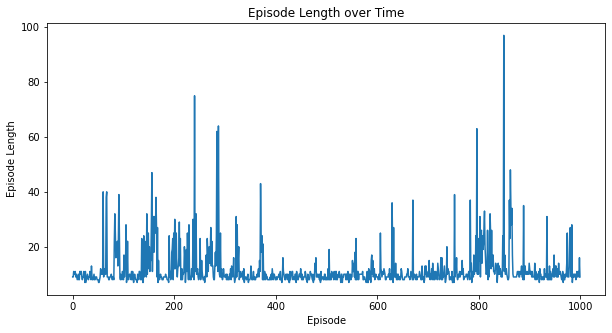

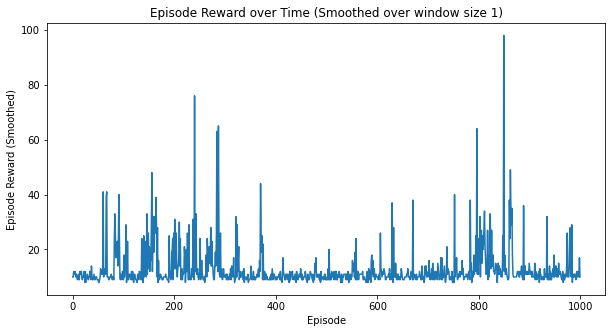

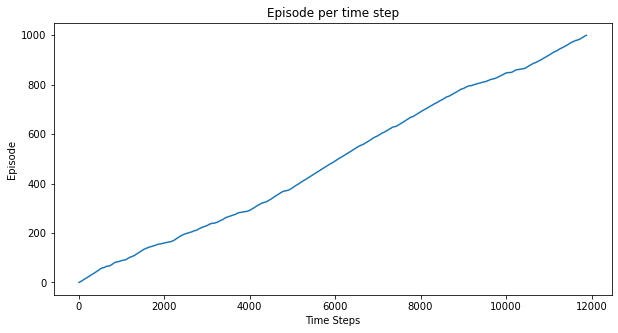

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [8]:
# Testing cell for my Agent
#env = gym.envs.make("MountainCar-v0") # Sparse reward system Not good for this current approach of using curious ANN
env = gym.envs.make("CartPole-v1")
#estimator = ANeuralNet(env.observation_space.shape[0]+env.action_space.n,256,1)
sarsa = QTrainer(env=env, lr=0.01, gamma=0.65, epsilon=0.1)
stats = sarsa.loop(num_episodes=1000)
plotting.plot_episode_stats(stats,smoothing_window=1)

In [5]:
# TESTING CELL For Neural Network Function approximator
pos = 1.0
vel = 0.3
state = torch.tensor([pos,vel])
actions = torch.eye(3)

q_input_state = torch.tile(state,(len(actions),1))
first_layer = torch.cat((q_input_state,actions),1)

print(f"(S) state:  {state.shape} \n{state}\n\ntransformed_state: \n {q_input_state} \n\n(A) actions  {actions.shape}\n{actions}\n\n First_layer_shape {first_layer.shape}\n{first_layer}")
model = ANeuralNet(len(state)+len(actions),128,1)
Q_vals = model(first_layer)
print(f"Q_vals: \n{Q_vals}")
Q_vals = model(first_layer)
print(f"Predicting with same Inputs Outputs \n{Q_vals}")

(S) state:  torch.Size([2]) 
tensor([1.0000, 0.3000])

transformed_state: 
 tensor([[1.0000, 0.3000],
        [1.0000, 0.3000],
        [1.0000, 0.3000]]) 

(A) actions  torch.Size([3, 3])
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

 First_layer_shape torch.Size([3, 5])
tensor([[1.0000, 0.3000, 1.0000, 0.0000, 0.0000],
        [1.0000, 0.3000, 0.0000, 1.0000, 0.0000],
        [1.0000, 0.3000, 0.0000, 0.0000, 1.0000]])
Q_vals: 
tensor([[-0.3326],
        [ 0.6272],
        [ 0.0981]], grad_fn=<AddmmBackward>)
Predicting with same Inputs Outputs 
tensor([[-0.3326],
        [ 0.6272],
        [ 0.0981]], grad_fn=<AddmmBackward>)


In [6]:
from sklearn.preprocessing import OneHotEncoder
action_encoder = OneHotEncoder().fit(np.array([0, 1, 2]).reshape((-1, 1)))
action_encoder.transform(np.array([0]).reshape((-1, 1))+1).A
old_state = np.array([1, 0.2]).reshape((-1, 2))
print(old_state)

[[1.  0.2]]
